# Time Series Project - Predicting Stock Price

In [462]:
# install yahoo finance

# %pip install yfinance

In [463]:
# import

import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

from scipy.signal import find_peaks, periodogram

from tabulate import tabulate

import sqlite3

# Preparing the Data

In [464]:
# set the ticker and date frame

ticker = "DAL"
start_date = "2022-04-01"
end_date = "2025-03-31"

In [465]:
# get the data

data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [466]:
# check the data

data

Price,Close,High,Low,Open,Volume
Ticker,DAL,DAL,DAL,DAL,DAL
Date,,,,,
2022-04-01,38.607456,39.186912,38.312815,38.961019,8606300
2022-04-04,38.695850,38.911916,38.018180,38.519067,9482700
2022-04-05,38.332458,39.157446,37.880680,38.803880,12713400
2022-04-06,36.918198,37.379799,36.063747,37.330690,16995200
2022-04-07,36.466412,36.829798,35.523566,36.702120,11688800
...,...,...,...,...,...
2025-03-24,48.880001,49.369999,47.700001,47.750000,9852900
2025-03-25,48.669998,49.990002,48.410000,49.599998,8227000


In [467]:
# remove multi-index

data = data.droplevel(level=1, axis=1).reset_index()
data

Price,Date,Close,High,Low,Open,Volume
0,2022-04-01,38.607456,39.186912,38.312815,38.961019,8606300
1,2022-04-04,38.695850,38.911916,38.018180,38.519067,9482700
2,2022-04-05,38.332458,39.157446,37.880680,38.803880,12713400
3,2022-04-06,36.918198,37.379799,36.063747,37.330690,16995200
4,2022-04-07,36.466412,36.829798,35.523566,36.702120,11688800
...,...,...,...,...,...,...
745,2025-03-24,48.880001,49.369999,47.700001,47.750000,9852900
746,2025-03-25,48.669998,49.990002,48.410000,49.599998,8227000
747,2025-03-26,48.070000,49.279999,47.509998,48.900002,6853200
748,2025-03-27,46.150002,48.000000,45.980000,47.520000,11157800


In [468]:
# create a new dataframe with just the date and close price

close = pd.DataFrame(columns=['Date', 'Close'])
close['Date'] = data['Date']
close['Close'] = data['Close']
close

,Date,Close
0,2022-04-01,38.607456
1,2022-04-04,38.695850
2,2022-04-05,38.332458
3,2022-04-06,36.918198
4,2022-04-07,36.466412
...,...,...
745,2025-03-24,48.880001
746,2025-03-25,48.669998
747,2025-03-26,48.070000
748,2025-03-27,46.150002


In [469]:
# make sure the data type of the Date column is datetime

close.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    750 non-null    datetime64[ns]
 1   Close   750 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.8 KB


In [470]:
# make the datetime the index

close = close.set_index('Date')
close

,Close
Date,
2022-04-01,38.607456
2022-04-04,38.695850
2022-04-05,38.332458
2022-04-06,36.918198
2022-04-07,36.466412
...,...
2025-03-24,48.880001
2025-03-25,48.669998
2025-03-26,48.070000


In [471]:
# auto detect the frequency of the datetime

inferred_freq = pd.infer_freq(close.index)
print(inferred_freq)

None


In [472]:
# manually set the frequency to business days, and fill missing dates with forward fill

close = close.asfreq('B')
close['Close'] = close['Close'].fillna(method='ffill')
close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 781 entries, 2022-04-01 to 2025-03-28
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   781 non-null    float64
dtypes: float64(1)
memory usage: 12.2 KB


/var/folders/bh/crnltg950_n8l07mfm97qdtc0000gn/T/ipykernel_52205/3438874196.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close['Close'] = close['Close'].fillna(method='ffill')


# Checking if the Data is Stationary

<Axes: xlabel='Date'>

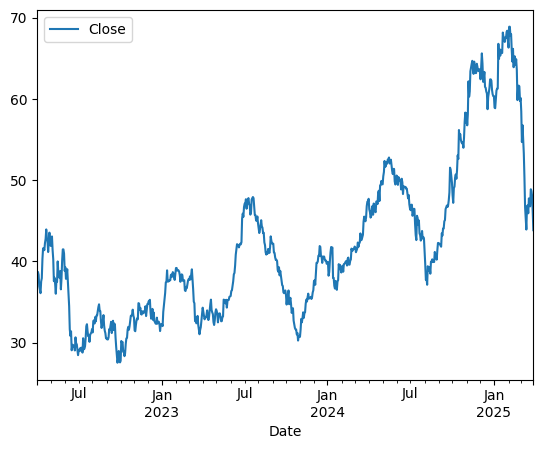

In [473]:
# plot the close prices

close.plot()

- the plot of the close prices show an upward trend in prices over time
- there is a vague pattern to the price increases and decreases, although it is difficult to tell if they repeat in a consistent manner or over what length of period of time
- I will calculate the rolling mean and standard deviations to confirm if the data is stationary

<Axes: xlabel='Date'>

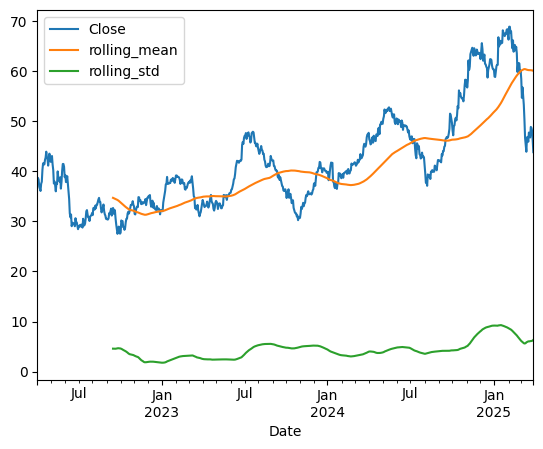

In [474]:
# calculate the rolling mean and rolling std

close['rolling_mean'] = close['Close'].rolling(120).mean()
close['rolling_std'] = close['Close'].rolling(120).std()

close.plot()

- the rolling mean shows a positive trend in the close price
- the rolling standard deviation also signals that the standard deviation is increasing over time
- based on the above, the data is not stationary. I will confirm this by using the ADFuller test
- the null hypothesis of the ADFuller test is that the data is not stationary, I would need a p value of less 0.05 in order to reject my null hypothesis

In [475]:
# use the ADFuller test to confirm that the data is not stationary

adfuller(close['Close'])

(-1.371567175193981,
 0.5958287424890591,
 0,
 780,
 {'1%': -3.4387614757350087,
  '5%': -2.865252556432172,
  '10%': -2.5687469247205788},
 2085.909281230367)

- the p-value of the ADF test is much greater than 0.05, which means I cannot reject the null hypothesis that the data is not stationary. 
- to make the data more stationary, I will remove non-constant variance by taking the log the close price, and then remove the trend by taking the difference of the logged close price. 

# Making the Data Stationary

<Axes: xlabel='Date'>

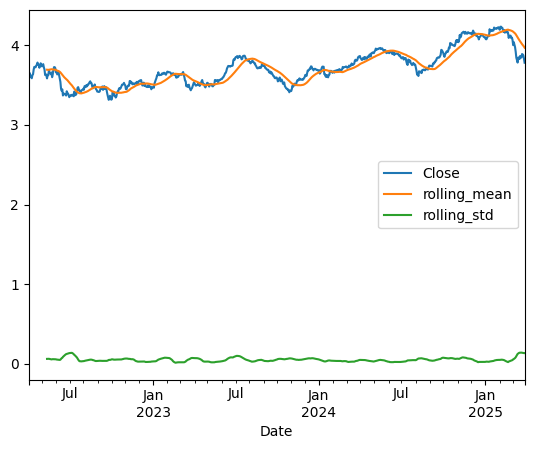

In [476]:
# create a copy of the dataframe with the log of the close price

close_log = close.copy()
close_log['Close'] = np.log(close_log['Close'])
close_log['rolling_mean'] = close_log['Close'].rolling(30).mean()
close_log['rolling_std'] = close_log['Close'].rolling(30).std()

close_log.plot()

- after taking the log of the close price, the variance is more consistent, but still increases over time 
- the rolling mean is also more stable, but there is still a slight upward trend

In [477]:
# check the adfuller p-value for the logged close price

adfuller(close_log['Close'])

(-1.4216575469950483,
 0.5718503126601555,
 0,
 780,
 {'1%': -3.4387614757350087,
  '5%': -2.865252556432172,
  '10%': -2.5687469247205788},
 -3610.680605517251)

- the p-value of the logged close price is again greater than 0.05, this means that I still cannot reject the null hypothesis that the data is not stationary. I will continue to make the data more stationary by taking different levels of differencing of the logged data. 

<Axes: xlabel='Date'>

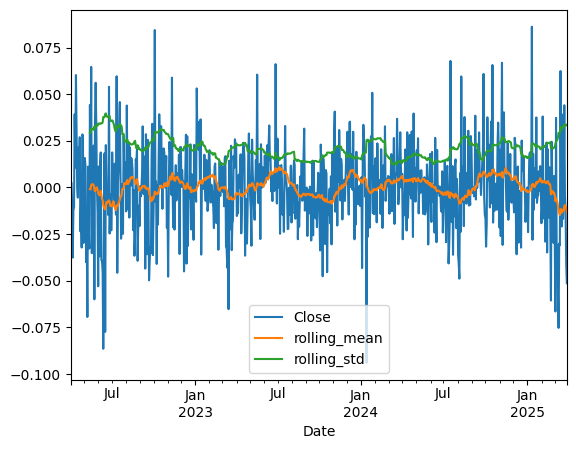

In [478]:
# create a copy of the dataframe with the log of the close price and 1 level of diff

close_log_diff = close.copy()
close_log_diff['Close'] = np.log(close_log_diff['Close']).diff()
close_log_diff['rolling_mean'] = close_log_diff['Close'].rolling(30).mean()
close_log_diff['rolling_std'] = close_log_diff['Close'].rolling(30).std()

close_log_diff.plot()

- the rolling mean and the rolling standard deviation both no longer have an obvious upward trend.
- I will check the adfuller p-value to see if the null hypothesis can be rejected or not.

In [479]:
# check the adfuller p-value on the logged close price with 1 level of difference

adfuller(close_log_diff['Close'].dropna())

(-18.261951755402766,
 2.3300286773763434e-30,
 1,
 778,
 {'1%': -3.438783171038672,
  '5%': -2.865262118650577,
  '10%': -2.568752018688748},
 -3604.280642063053)

- the p-value is very small, this means that we can reject the null hypothesis that the data is non-stationary. 
- I will continue to check additional levels of differencing

<Axes: xlabel='Date'>

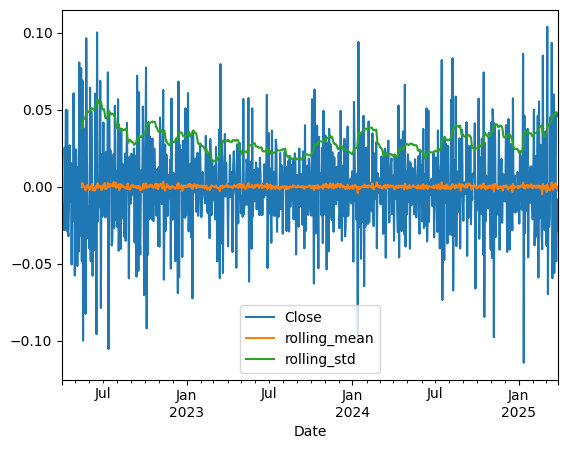

In [480]:
# create a copy of the dataframe with the log of the close price and 2 levels of diff

close_log_diff_diff = close.copy()
close_log_diff_diff['Close'] = np.log(close_log_diff_diff['Close']).diff().diff()
close_log_diff_diff['rolling_mean'] = close_log_diff_diff['Close'].rolling(30).mean()
close_log_diff_diff['rolling_std'] = close_log_diff_diff['Close'].rolling(30).std()

close_log_diff_diff.plot()

- at 2 levels of differencing, the rolling mean shows no trend at all, and the standard deviation does not show any overarching trends of increase or decrease.
- I will check the adfuller p-value to confirm. 

In [481]:
# check the adfuller p-value

adfuller(close_log_diff_diff['Close'].dropna())

(-10.62862953436258,
 5.284684251153593e-19,
 19,
 759,
 {'1%': -3.4389949984547465,
  '5%': -2.865355478124818,
  '10%': -2.568801753520772},
 -3553.08069854329)

- the p-value is very small, but greater than at 1 level of diff. Again, we can reject the null hypothesis that the data is not stationary. 
- since the p-value increased with 2 levels of diff, it means that the data already became stationary at 1 level of diff, and that additional levels of diff may or may not be unnecessary.

# Check for Seasonality

Differencing helps to alleviate seasonality, but the ADFuller test does not check for seasonality, so I will double check that there is no more seasonality left in the transformed data by using the following methods:
1. Seasonal decompose to visualize seasonality
2. Calculate the period of seasonality using periodogram

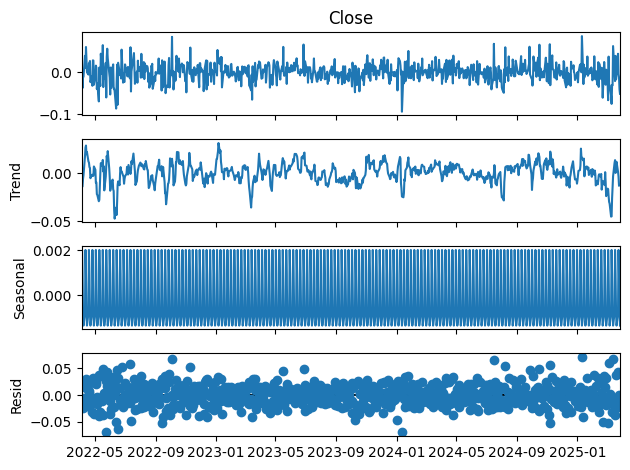

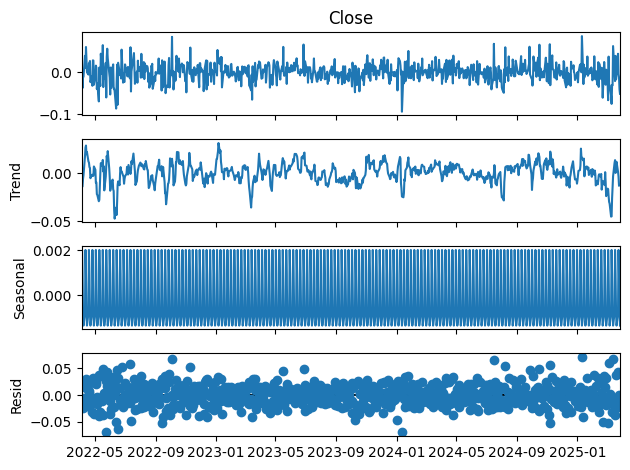

In [482]:
# use seasonal decompose to visualize any seasonality in the data

seasonal_results = seasonal_decompose(close_log_diff['Close'].dropna())
seasonal_results.plot()

- The seasonal plot shows a repeating pattern, which indicates that there may be seasonality in the data. 
- I will next try to calculate the length of the seasonal period using perdiogram

In [483]:
# calculate the periods using periodogram

# compute the power spectrum
frequencies, power = periodogram(close_log['Close'].dropna())

# find peaks in the power specturm
peaks, _ = find_peaks(power, height=0.1 * max(power))

# convert frequency to period
periods = (1 / frequencies[peaks])

# return the period
periods

array([781.  , 195.25])

- the periods that the periodogram found significant are 781 and 195.25 business days. 
- 781 is the length of the data, so this indicates that there is an overarching trend across the entire time period
- 195.25 business days translate to roughly 275 days on the standard calendar, which is 3 quarters of a year
- I will next plot the periods to visualize the peaks in the frequencies

/var/folders/bh/crnltg950_n8l07mfm97qdtc0000gn/T/ipykernel_52205/1824241897.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.plot((1/frequencies), power)


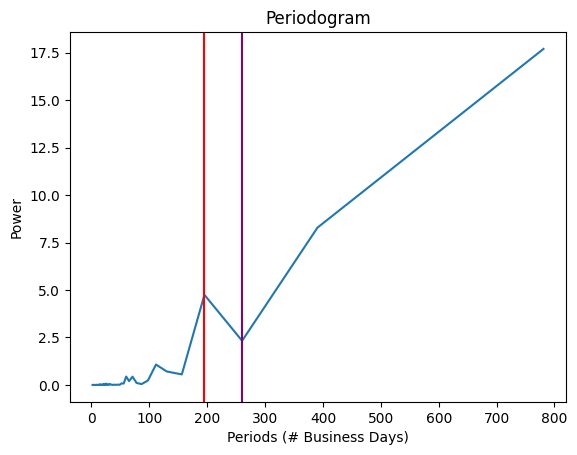

In [484]:
# plot the periods (1/frequencies)

plt.plot((1/frequencies), power)
plt.title("Periodogram")
plt.xlabel("Periods (# Business Days)")
plt.ylabel("Power")
plt.axvline(x=195.25, color='red');
plt.axvline(x=260, color='purple');

- the above plot shows the frequencies that were found by the power spectrum.
- there is a peak around 200, which correlates to the 195.25 found previously
- after 260, the power continues to increase, this is likely due to a trend in the data (which will be addressed through differencing)
- I will remove the seasonality next

# Removing Seasonality

<Axes: xlabel='Date'>

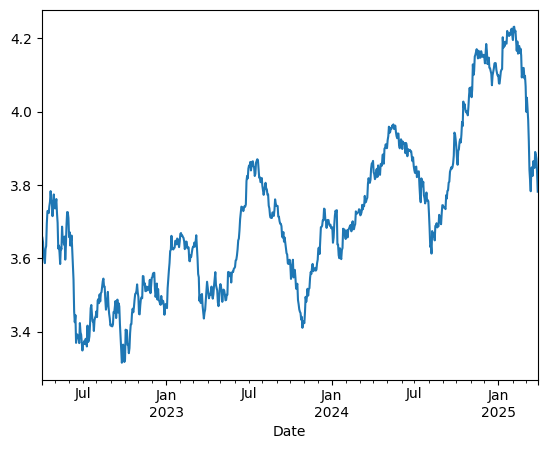

In [485]:
# save the seasonal element from the results

seasonal = seasonal_results.seasonal

# remove the seasonality by subtracting it from the close prices

close_log_season = close_log.copy()
close_log_season['Close'] = (close_log['Close'] - seasonal)
close_log_season['Close'].plot()

### Analyze the ACF and PACF plots for best p, d, q

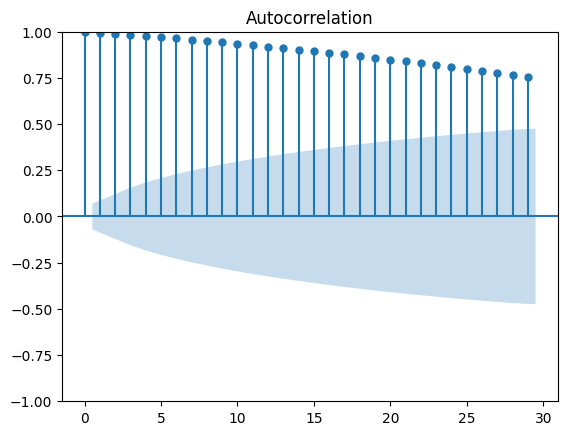

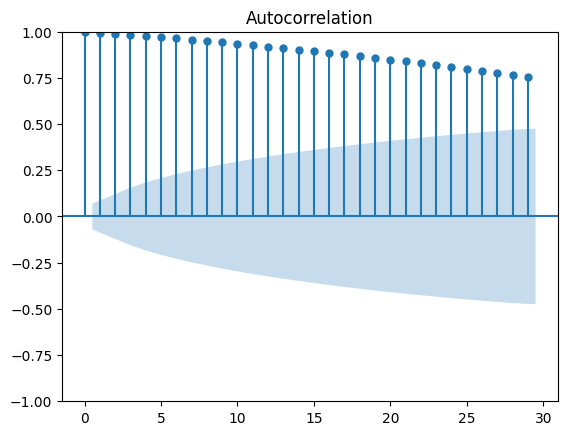

In [486]:
# plot the acf with the log-transformed data and seasonality removed

plot_acf(close_log_season['Close'].dropna())

- the gradually decreasing ACF plot indicates autoregressive characteristics which means that there are predictable patterns based on past values. This confirms that I should consider AR terms in my model.

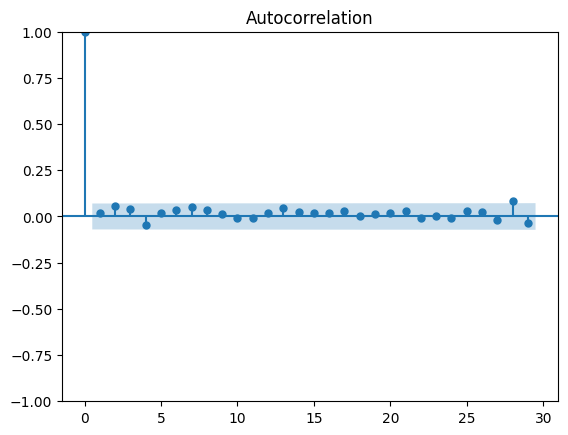

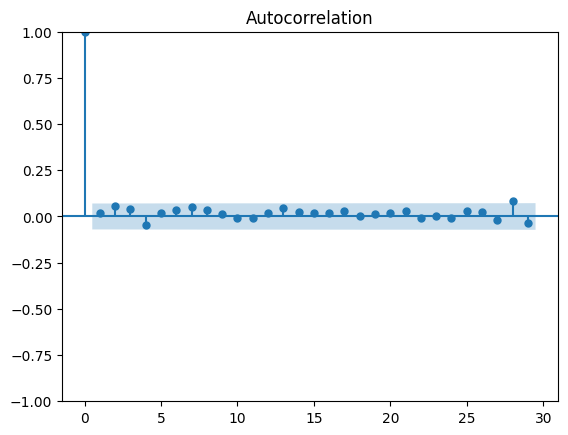

In [487]:
# plot the acf with 1 level of diff

plot_acf(close_log_season['Close'].diff().dropna())

- The ACF shows no significant autocorrelation after lag of 0. 
- This suggests that when using 1 level of diff the MA component in the ARIMA model may be 0 (q = 0). 

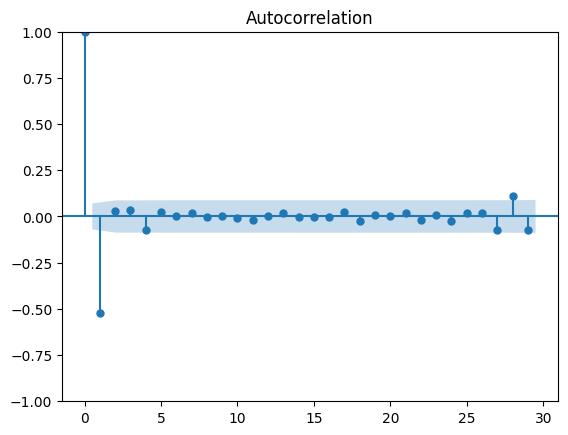

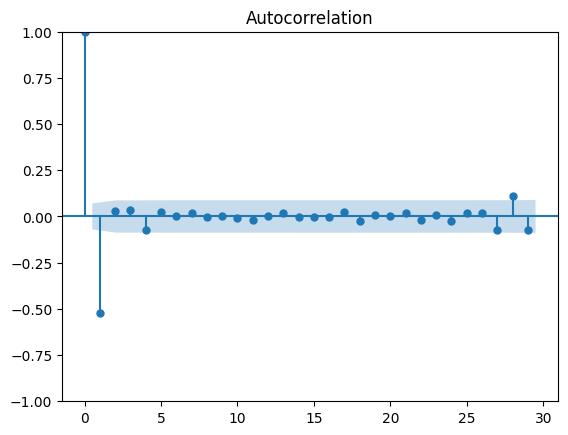

In [488]:
# plot the acf with 2 levels of diff

plot_acf(close_log_season['Close'].diff().diff().dropna())

- The ACF shows no significant autocorrelation after lag of 1. 
- This suggests that when using 2 levels of diff, the MA component in the ARIMA model may be 1 (q = 1). 

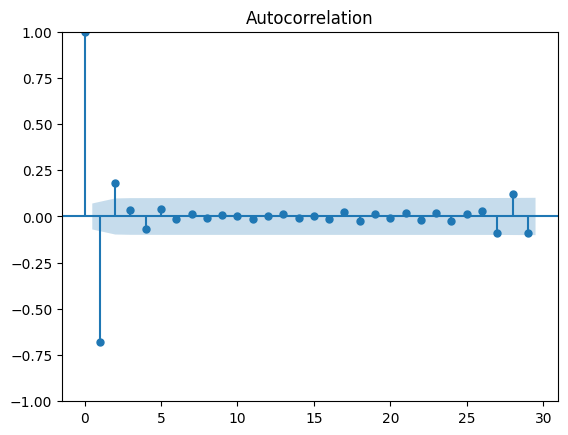

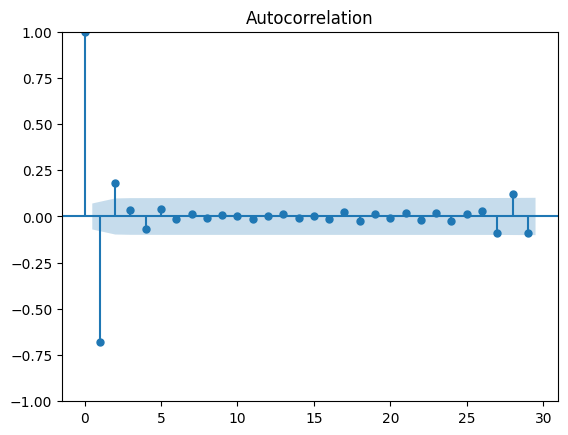

In [489]:
# plot the acf with 3 levels of diff

plot_acf(close_log_season['Close'].diff().diff().diff().dropna())

- The ACF shows no significant autocorrelation after lag of 1. 
- This suggests that when using 3 levels of diff, the MA component in the ARIMA model may be 2 (q = 2). 

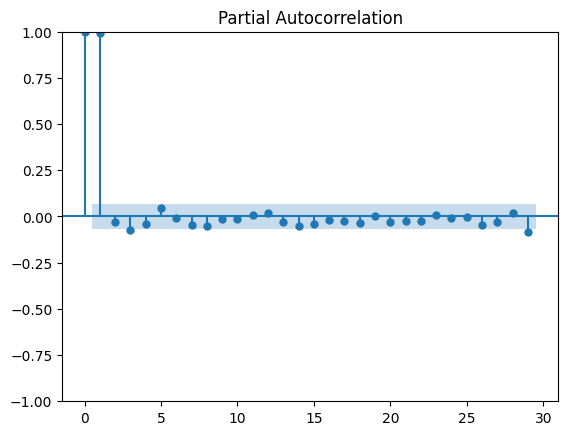

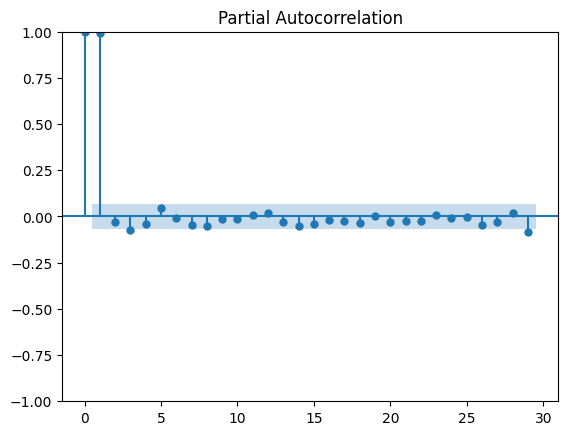

In [490]:
# plot the pacf

plot_pacf(close_log_season['Close'].dropna())

- With no differencing, the PACF shows a significant drop after lag 1, suggesting that the AR component in the ARIMA model may be 1 (p = 1). 

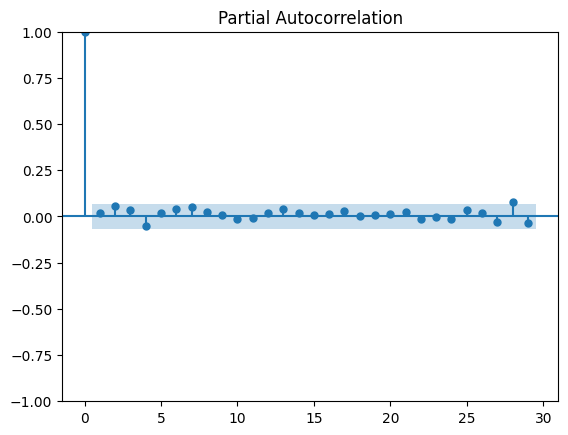

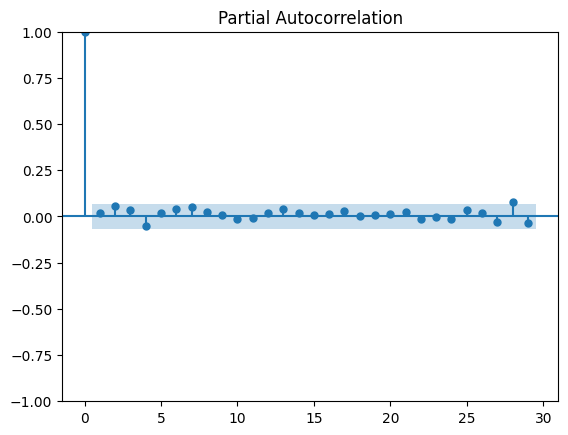

In [491]:
# plot the pacf with 1 level of diff

plot_pacf(close_log_season['Close'].diff().dropna())

- With 1 level of differencing, the PACF shows no significant autocorrelation after lag 0, suggesting that the AR component in the ARIMA model may be 0 (p = 0). 

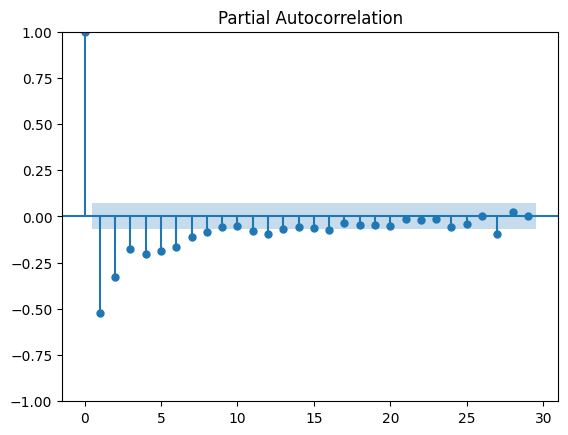

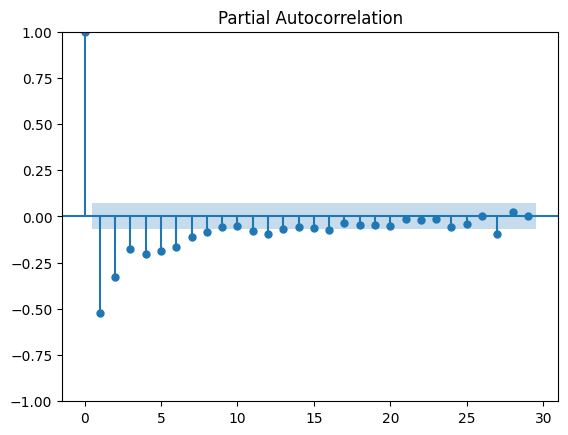

In [492]:
# plot the pacf with 2 levels of diff

plot_pacf(close_log_season['Close'].diff().diff().dropna())

- With 2 levels of differencing, the PACF shows significant autocorrelation up to lag 8, suggesting that the AR component in the ARIMA model may be 8 (p = 8). 

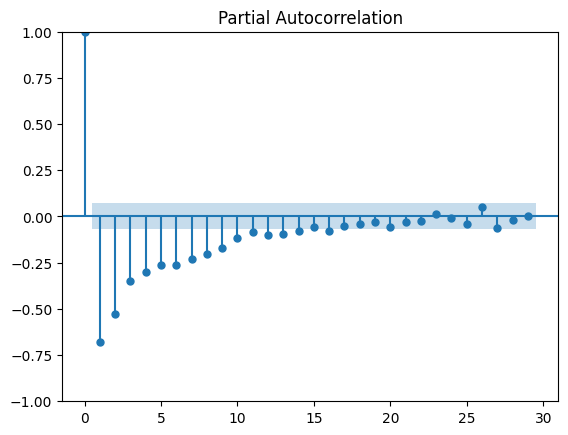

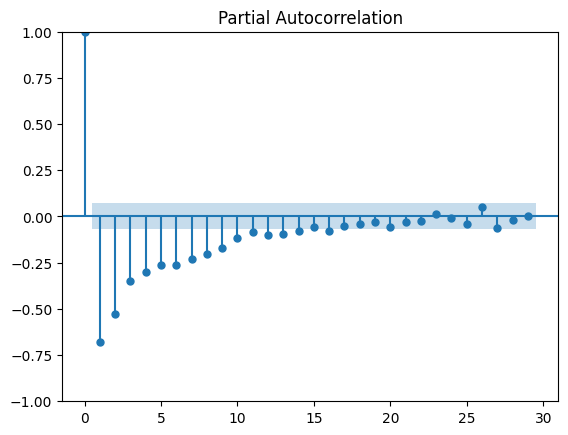

In [493]:
# plot the pacf with 3 levels of diff

plot_pacf(close_log_season['Close'].diff().diff().diff().dropna())

- With 3 levels of differencing, the PACF shows significant autocorrelation up to lag 17, suggesting that the AR component in the ARIMA model may be 17 (p = 17). 

In [494]:
# confirming that the data is not non-stationary using adfuller

final_transform_adf = adfuller(close_log_season['Close'].diff().diff().dropna())
final_transform_adf

(-11.903124650004775,
 5.515214756356331e-22,
 15,
 762,
 {'1%': -3.4389608473398194,
  '5%': -2.8653404270188476,
  '10%': -2.568793735369693},
 -3552.2217174899797)

### Based on the ACF and PACF plots, my best hyperparameters are q=1, d=2, p=8

# ARIMA Model

In [495]:
# train test split

train, test = train_test_split(close_log_season['Close'].dropna(), test_size=60, shuffle=False)

display(train.head())
display(train.tail())
display(test.head())
display(test.tail())

Date
2022-04-04    3.656547
2022-04-05    3.644274
2022-04-06    3.607758
2022-04-07    3.597178
2022-04-08    3.587202
Freq: B, Name: Close, dtype: float64

Date
2024-12-30    4.104654
2024-12-31    4.098186
2025-01-01    4.099263
2025-01-02    4.077075
2025-01-03    4.076472
Freq: B, Name: Close, dtype: float64

Date
2025-01-06    4.093392
2025-01-07    4.109363
2025-01-08    4.114355
2025-01-09    4.116088
2025-01-10    4.202881
Freq: B, Name: Close, dtype: float64

Date
2025-03-24    3.890183
2025-03-25    3.883039
2025-03-26    3.871712
2025-03-27    3.832683
2025-03-28    3.781916
Freq: B, Name: Close, dtype: float64

In [496]:
# set my best hyperparameters based on the acf and pacf plots

q = 1
d = 2
p = 8

# define the ARIMA model

model8_2_1 = ARIMA(train, order=(p,d,q))
results_model8_2_1 = model8_2_1.fit()

# check the results summary

results_model8_2_1.summary()

/Users/annahan/Documents/GitHub/learning-fuze/live_class_W1D2_0125/.conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  720
Model:                 ARIMA(8, 2, 1)   Log Likelihood                1707.990
Date:                Sat, 05 Apr 2025   AIC                          -3395.979
Time:                        19:06:48   BIC                          -3350.214
Sample:                    04-04-2022   HQIC                         -3378.309
                         - 01-03-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2624      0.089     -2.956      0.003      -0.436      -0.088
ar.L2         -0.1676      0.080     -2.100      0.036      -0.324      -0.011
ar.L3         -0.1528      0.075     -2.038      0.042      -0.300      -0.006
ar.L4         -0.2201      0.060     -3.691      0.000      -0.337      -0.103
ar.L5         -0.1898      0.053     -3.586      0.000      -0.293      -0.086
ar.L6         -0.1754      0.058     -3.029      0.002      -0.289      -0.062
ar.L7         -0.1363      0.051     -2.699      0.007      -0.235      -0.037
ar.L8         -0.0575      0.049     -1.178      0.239      -0.153       0.038
ma.L1         -0.6887      0.080     -8.557      0.000      -0.846      -0.531
sigma2         0.0005   2.44e-05     21.877      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.61   Jarque-Bera (JB):                66.15
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The SARIMAX results:
1. Ljung-Box prob(Q) is high, which means that there are no significant autocorrelations left in the residuals
2. Jarque-Bera prob(JB) is low, indicating that residuals are not normally distributed, which can affect confidence intervals, but forecasting models may still work well 
3. Heteroskedasticity prob(H) is also low, which indicates that heteroskedasticity is still present

- Next, I will evaluate the model by predicting test and calculating the RMSE

(14292.0, 14351.0)

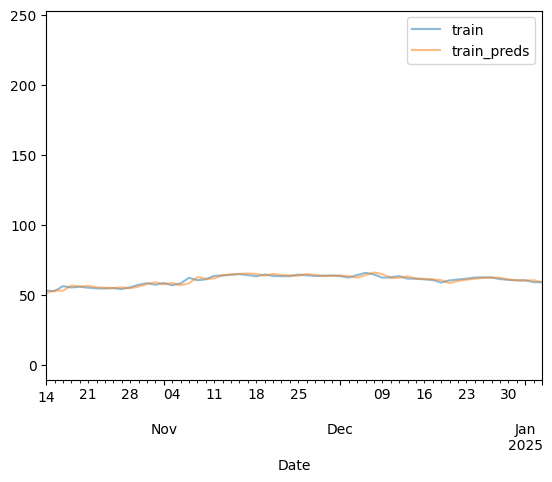

In [497]:
# get the predictions

train_preds_model8_2_1 = results_model8_2_1.fittedvalues

# build a df to store predictions

results_model8_2_1_train = pd.DataFrame(columns=['train','train_preds'])
results_model8_2_1_train['train'] = np.exp(train)
results_model8_2_1_train['train_preds'] = np.exp(train_preds_model8_2_1)
results_model8_2_1_train.plot(alpha = 0.5)
plt.xlim(train.index[-60], train.index[-1])

<Axes: xlabel='Date'>

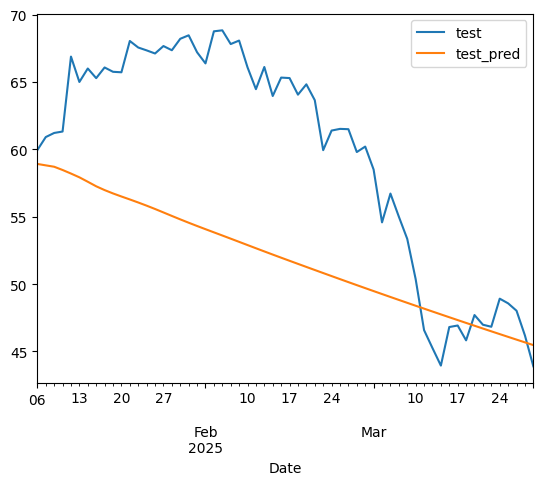

In [498]:
# forecasting test

forecast_60_days = results_model8_2_1.forecast(steps=len(test))
forecast_60_days

test_results_model8_2_1 = pd.DataFrame(columns=['test','test_pred'])
test_results_model8_2_1['test'] = np.exp(test)
test_results_model8_2_1['test_pred'] = np.exp(forecast_60_days)
test_results_model8_2_1.plot()

In [499]:
# calculate the metrics for the model

model8_2_1_train_rmse = root_mean_squared_error(results_model8_2_1_train['train'], results_model8_2_1_train['train_preds'])
model8_2_1_test_rmse = root_mean_squared_error(test_results_model8_2_1['test'], test_results_model8_2_1['test_pred'])

print('Train RMSE', model8_2_1_train_rmse)
print('Test RMSE', model8_2_1_test_rmse)

Train RMSE 7.7371824755668035
Test RMSE 9.475077538855158


- The RMSE is lower on train than on test, this indicates the model is overfit
- I will try to improve the model by using AutoARIMA to search for the best hyperparameters

In [500]:
# create a dataframe to store all of the best models from each method

best_models = pd.DataFrame(columns=['model', 'hyperparameters', 'train RMSE', 'test RMSE'])

new_row_arima8_2_1 = pd.DataFrame([{'model': 'ARIMA using acf and pacf',
                                    'hyperparameters': 'p=8, d=2, q=1',
                                    'train RMSE': model8_2_1_train_rmse,
                                    'test RMSE': model8_2_1_test_rmse}])
best_models = pd.concat([best_models, new_row_arima8_2_1], ignore_index=True)

best_models

/var/folders/bh/crnltg950_n8l07mfm97qdtc0000gn/T/ipykernel_52205/1266780219.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  best_models = pd.concat([best_models, new_row_arima8_2_1], ignore_index=True)


,model,hyperparameters,train RMSE,test RMSE
0,ARIMA using acf and pacf,"p=8, d=2, q=1",7.737182,9.475078


# Using AutoARIMA to search for the best hyperparameters

In [501]:
# import pmdarima

import pmdarima as pm

In [502]:
# set the search parameters

pmarima = pm.AutoARIMA(start_p=0, max_p=10, start_d=0, max_d=3, start_q=0, max_q=5, seasonal=False, random_state=42,
                       stepwise=True, suppress_warnings=True, error_action='ignore', trace=True)

In [503]:
# fit the model

pmarima.fit(train)

# get the best model
model=pmarima.model_
model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3463.309, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3461.540, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3461.513, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3464.789, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3460.423, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.178 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  720
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1733.394
Date:                Sat, 05 Apr 2025   AIC                          -3464.789
Time:                        19:06:49   BIC                          -3460.211
Sample:                    04-04-2022   HQIC                         -3463.022
                         - 01-03-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0005   1.89e-05     24.946      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                64.83
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- the best model from the autoARIMA search is (0,1,0), which only uses differencing, and no autoregressive or moving average terms.

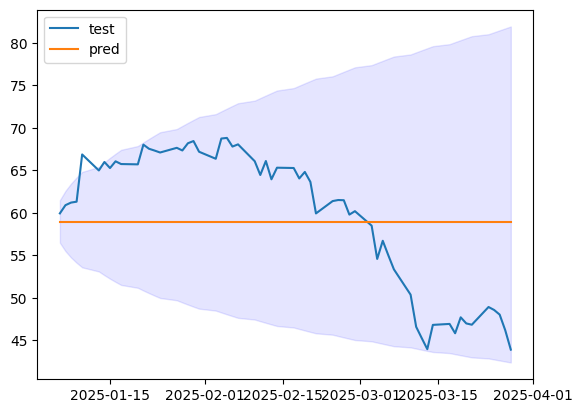

In [504]:
# get the predictions from the best model

pm_test_pred, confs = model.predict(n_periods=len(test), return_conf_int=True)

# plot the predictions

plt.plot(np.exp(test), label='test')
plt.plot(np.exp(pm_test_pred), label='pred')
plt.fill_between(test.index, np.exp(confs[:,0]), np.exp(confs[:,1]), color='blue', alpha=.1)
plt.legend()

- the model is predicting a constant price

In [505]:
# store the test predictions

pm_test_preds = pd.DataFrame(columns=['test','test_preds'])
pm_test_preds['test'] = np.exp(test)
pm_test_preds['test_preds'] = np.exp(pm_test_pred)

In [506]:
# get the train predictions

pm_train_pred = model.predict_in_sample()

In [507]:
# store the train predictions

pm_train_preds = pd.DataFrame(columns=['train','train_preds'])
pm_train_preds['train'] = np.exp(train)
pm_train_preds['train_preds'] = np.exp(pm_train_pred)

In [508]:
# calculate the metrics for the model

arima010_train_rmse = root_mean_squared_error(pm_train_preds['train'], pm_train_preds['train_preds'])
arima010_test_rmse = root_mean_squared_error(pm_test_preds['test'], pm_test_preds['test_preds'])

print('Train RMSE', arima010_train_rmse)
print('Test RMSE', arima010_test_rmse)

Train RMSE 1.6508376428720364
Test RMSE 8.25956391137282


- the RMSE for the autoARIMA's best model is lower than the RMSE of the model with manually select hyperparameters. However, the autoARIMA's best hyperparameters is basically just predicting the previous day, it is a very simple model and does not include auto-regression or moving average.
- instead of using autoARIMA to find the best model, I will do a manual loop to find the best hyperparameters that give me the best test RMSE

In [509]:
# add results to best model dataframe

new_row_arima0_1_0 = pd.DataFrame([{'model': 'ARIMA using autoARIMA',
                                    'hyperparameters': 'p=0, d=1, q=0',
                                    'train RMSE': arima010_train_rmse,
                                    'test RMSE': arima010_test_rmse}])
best_models = pd.concat([best_models, new_row_arima0_1_0], ignore_index=True)

best_models

,model,hyperparameters,train RMSE,test RMSE
0,ARIMA using acf and pacf,"p=8, d=2, q=1",7.737182,9.475078
1,ARIMA using autoARIMA,"p=0, d=1, q=0",1.650838,8.259564


# Manual loop over ARIMA

In [510]:
# create a function that accepts different values of p, d and q and outputs the train RMSE and test RMSE

def arima_search(train, test, p, q, d):
  arima_model = ARIMA(train, order=(p,d,q))
  arima_result = arima_model.fit()

  # get the train predictions
  train_pred = arima_result.fittedvalues

  # build a df to store train predictions
  train_preds = pd.DataFrame(columns=['train','train_pred'])
  train_preds['train'] = np.exp(train)
  train_preds['train_pred'] = np.exp(train_pred)

  # get the test predictions
  test_pred = arima_result.forecast(steps=len(test))

  # build a df to store test predictions
  test_preds = pd.DataFrame(columns=['test','test_pred'])
  test_preds['test'] = np.exp(test)
  test_preds['test_pred'] = np.exp(test_pred)

  train_RMSE = root_mean_squared_error(train_preds['train'], train_preds['train_pred'])
  test_RMSE = root_mean_squared_error(test_preds['test'], test_preds['test_pred'])

  return train_RMSE, test_RMSE

In [511]:
# loop over a ranges of p, q, and d and store the train and test RMSE to a list

from itertools import product

p_range = list(range(0,6))
q_range = list(range(0,6))
d_range = list(range(1,3))

ARIMA_results = []

for p, q, d in product(p_range, q_range, d_range):
  try:
    train_rmse, test_rmse = arima_search(
      train, test,
      p=p,
      q=q,
      d=d
    )
    ARIMA_results.append({
      'p': p,
      'd': d,
      'q': q,
      'train_rmse': train_rmse,
      'test_rmse': test_rmse
    })
  except Exception as e:
    print(f"Failed for p={p}, d={d}, q={q} — Error: {e}")


/Users/annahan/Documents/GitHub/learning-fuze/live_class_W1D2_0125/.conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/annahan/Documents/GitHub/learning-fuze/live_class_W1D2_0125/.conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/annahan/Documents/GitHub/learning-fuze/live_class_W1D2_0125/.conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/annahan/Documents/GitHub/learning-fuze/live_class_W1D2_0125/.conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: Convergence

In [512]:
# turn the results list into a dataframe, then sort, with the best test RMSE on top
ARIMA_results_df = pd.DataFrame(ARIMA_results)

best_arima_loop = ARIMA_results_df.sort_values(by='test_rmse').reset_index(drop=True)
best_arima_loop.head(10)

,p,d,q,train_rmse,test_rmse
0,5,2,1,7.735302,7.796901
1,0,2,0,7.782255,7.949897
2,3,1,4,1.650200,8.242898
3,3,1,3,1.649856,8.249029
4,4,1,4,1.649921,8.252777
5,0,1,0,1.650838,8.259564
6,0,1,1,1.650830,8.259586
7,1,1,0,1.650842,8.259626
8,4,1,0,1.650577,8.262137
9,4,1,1,1.650577,8.262178


- The best test RMSE is at p=5, d=2, q=1

In [513]:
# transform the dataframe to markdown

print(tabulate(best_arima_loop.head(10), tablefmt="pipe", headers="keys", showindex=False))

|   p |   d |   q |   train_rmse |   test_rmse |
|----:|----:|----:|-------------:|------------:|
|   5 |   2 |   1 |      7.7353  |     7.7969  |
|   0 |   2 |   0 |      7.78225 |     7.9499  |
|   3 |   1 |   4 |      1.6502  |     8.2429  |
|   3 |   1 |   3 |      1.64986 |     8.24903 |
|   4 |   1 |   4 |      1.64992 |     8.25278 |
|   0 |   1 |   0 |      1.65084 |     8.25956 |
|   0 |   1 |   1 |      1.65083 |     8.25959 |
|   1 |   1 |   0 |      1.65084 |     8.25963 |
|   4 |   1 |   0 |      1.65058 |     8.26214 |
|   4 |   1 |   1 |      1.65058 |     8.26218 |


/Users/annahan/Documents/GitHub/learning-fuze/live_class_W1D2_0125/.conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='Date'>

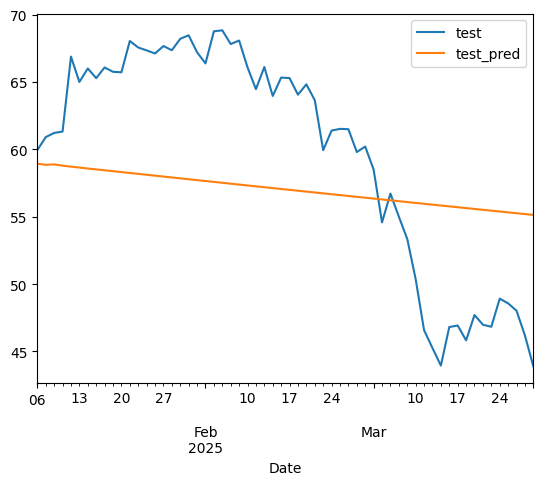

In [514]:
# plot the best model from the manual ARIMA search

arima_loop = ARIMA(train, order=(5,2,1))
arima_loop_results = arima_loop.fit()

# get the train predictions
arima_loop_train_pred = arima_loop_results.fittedvalues

# build a df to store train predictions
arima_loop_train_preds = pd.DataFrame(columns=['train','train_pred'])
arima_loop_train_preds['train'] = np.exp(train)
arima_loop_train_preds['train_pred'] = np.exp(arima_loop_train_pred)

# get the test predictions
arima_loop_test_pred = arima_loop_results.forecast(steps=len(test))

# build a df to store test predictions
arima_loop_test_preds = pd.DataFrame(columns=['test','test_pred'])
arima_loop_test_preds['test'] = np.exp(test)
arima_loop_test_preds['test_pred'] = np.exp(arima_loop_test_pred)

arima_loop_train_RMSE = root_mean_squared_error(arima_loop_train_preds['train'], arima_loop_train_preds['train_pred'])
arima_loop_test_RMSE = root_mean_squared_error(arima_loop_test_preds['test'], arima_loop_test_preds['test_pred'])

arima_loop_test_preds.plot()


In [515]:
# add the results to the best model dataframe for comparison later

new_row_arima_loop = pd.DataFrame([{'model': 'ARIMA search loop',
                                    'hyperparameters': 'p=5, d=2, q=1',
                                    'train RMSE': arima_loop_train_RMSE,
                                    'test RMSE': arima_loop_test_RMSE}])
best_models = pd.concat([best_models, new_row_arima_loop], ignore_index=True)

best_models

,model,hyperparameters,train RMSE,test RMSE
0,ARIMA using acf and pacf,"p=8, d=2, q=1",7.737182,9.475078
1,ARIMA using autoARIMA,"p=0, d=1, q=0",1.650838,8.259564
2,ARIMA search loop,"p=5, d=2, q=1",7.735302,7.796901


# Modeling using Prophet

In [516]:
from prophet import Prophet

# create a model
m = Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale=15.0)
m.add_seasonality(name='custom_seasonality', period=195, fourier_order=5)
prophet_train = np.exp(train).reset_index()

# rename the columns to ds and y
prophet_train.columns = ['ds', 'y']
prophet_train

# fit the data
m.fit(prophet_train)

19:07:04 - cmdstanpy - INFO - Chain [1] start processing
19:07:05 - cmdstanpy - INFO - Chain [1] done processing


- In a prophet model, changepoint_prior_scale and seasonality_prior_scale control the flexibility of how much the model is allowed to bend to fit the data. 
- A low value in changepoint_prior_scale means that the trend line is more stable, which is good for when the data that has noise and we just want to capture the overall direction. A high value means that the model will allow sudden jumps in trend, so that is can account for real disruptions. 
- A low value in seasonality_prior_scale means that the seasonality is smooth and simple, while a high value allows for more complex seasonal patterns.
- I am choosing a high seasonality_prior_scale, because the seasonality in the data is complicated and does not have a clear, simple, pattern.
- I am choosing a high changepoint_prior_scale as well because the trend is not consistent, it involves frequent fluctuation. 
- add_seasonality allows me to define a custom seasonal component beyond the default ones, which are yearly, weekly and daily. I am defining the custom seasonal component to the peak that was discovered by the periodogram, which was 195 days. 
- The fourier_order controls how complex the seasonal component is allowed to be. It utilizes sine and cosine terms to model the seasonal cycle. A higher value means that seasonal patterns can be flexible and detailed, while a lower values means smoother and simpler seasonality. Low values are between 3-5, medium values range from 10-15, and high values are over 20.
- I am selecting a low fourier_order, because stock prices are subject to many external factors, and I do not want the model to overfit on the noise.

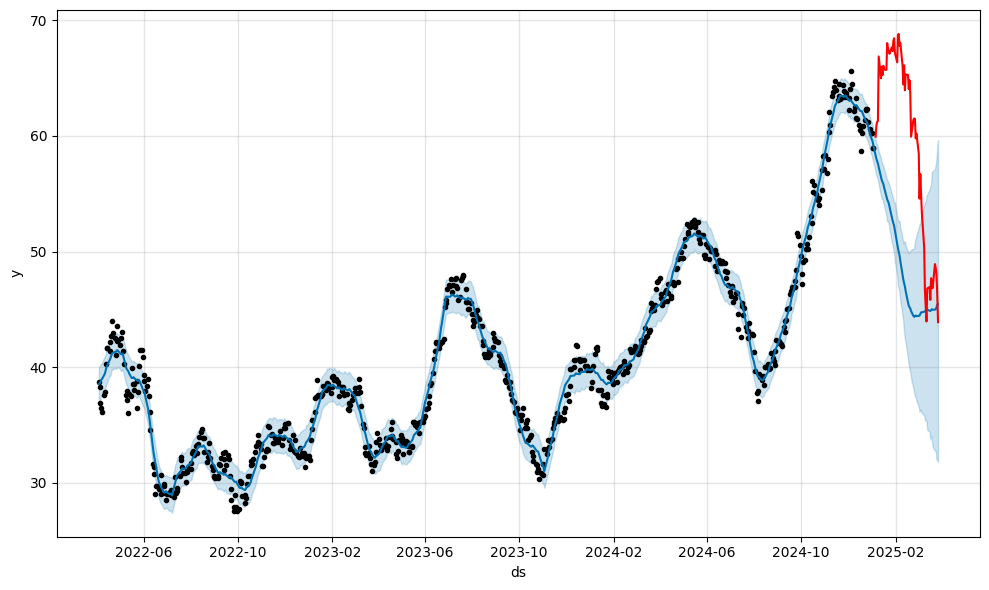

In [517]:
# make a future dataframe

future = m.make_future_dataframe(periods=len(test), freq='B')
forecast = m.predict(future)
m.plot(forecast)
# plt.xlim(test.index[0], test.index[-1])
plt.plot(np.exp(test), label='test', color='red');

- unlike the ARIMA model, the predictions are not a straight line, and they seem to continue the up and down pattern that is historically seen in this particular stock.

In [518]:
# predict the train
train_forecast = m.predict(prophet_train[['ds']])

# merge actual (exp(train)) and predicted (yhat) by 'ds'
m_train_preds = prophet_train[['ds']].copy()
m_train_preds['train'] = np.exp(train.values)
m_train_preds = m_train_preds.merge(train_forecast[['ds', 'yhat']], on='ds', how='left')
m_train_preds.rename(columns={'yhat': 'm_train_pred'}, inplace=True)

In [519]:
# save the predictions for only the test time period
m_test_preds = [forecast.loc[forecast['ds'] == month, 'yhat'].values[0] for month in test.index]

# save the predictions in a dataframe
m_test_results = pd.DataFrame(columns = ['test', 'm_test_pred'])
m_test_results['test'] = np.exp(test)
m_test_results['m_test_pred'] = m_test_preds

# get the metrics for the Prophet model
print('Train RMSE', root_mean_squared_error(m_train_preds['train'], m_train_preds['m_train_pred']))
print('Test RMSE', root_mean_squared_error(m_test_results['test'], m_test_results['m_test_pred']))

Train RMSE 1.121157884215923
Test RMSE 12.651613953798316


- The RMSE for my Prophet model with manually selected hyperparameters is higher than that of the autoARIMA model
- The train RMSE is much lower than that of test, which indicates that it is extremely overfit
- I will use a loop to find the best hyperparameters for the Prophet model

In [520]:
# create a function to try different hyperparameters in the prophet model and then loop over it

def prophet_search(changepoint_prior_scale=0.5, seasonality_prior_scale=15.0, period=195, fourier_order=5):
  # create a model
  m = Prophet(changepoint_prior_scale=changepoint_prior_scale, seasonality_prior_scale=seasonality_prior_scale)
  m.add_seasonality(name='custom_seasonality', period=period, fourier_order=fourier_order)
  prophet_train = np.exp(train).reset_index()

  # rename the columns to ds and y
  prophet_train.columns = ['ds', 'y']
  prophet_train

  # fit the data
  m.fit(prophet_train)

  future = m.make_future_dataframe(periods=len(test), freq='B')
  forecast = m.predict(future)

  # predict the train
  train_forecast = m.predict(prophet_train[['ds']])

  # merge actual (exp(train)) and predicted (yhat) by 'ds'
  m_train_preds = prophet_train[['ds']].copy()
  m_train_preds['train'] = np.exp(train.values)
  m_train_preds = m_train_preds.merge(train_forecast[['ds', 'yhat']], on='ds', how='left')
  m_train_preds.rename(columns={'yhat': 'm_train_pred'}, inplace=True)

  # save the predictions for only the test time period
  m_test_preds = [forecast.loc[forecast['ds'] == month, 'yhat'].values[0] for month in test.index]

  # save the predictions in a dataframe
  m_test_results = pd.DataFrame(columns = ['test', 'm_test_pred'])
  m_test_results['test'] = np.exp(test)
  m_test_results['m_test_pred'] = m_test_preds

  train_RMSE = root_mean_squared_error(m_train_preds['train'], m_train_preds['m_train_pred'])
  test_RMSE = root_mean_squared_error(m_test_results['test'], m_test_results['m_test_pred'])

  return train_RMSE, test_RMSE

In [521]:
# test the function

train_RMSE, test_RMSE = prophet_search(changepoint_prior_scale=0.1, seasonality_prior_scale=20.0, period=195, fourier_order=4)
train_RMSE, test_RMSE

19:07:05 - cmdstanpy - INFO - Chain [1] start processing
19:07:05 - cmdstanpy - INFO - Chain [1] done processing


(1.4626354098562266, 7.2249046697302175)

In [522]:
# define the hyperparameters ranges

changepoint_prior_scales = [0.05, 0.1, 0.2, 0.3]
seasonality_prior_scales = [5.0, 10.0, 20.0]
fourier_orders = [3, 4, 5]
periods = [195]

In [523]:
# use itertools.product to do a search over the hyperparameters

from itertools import product

prophet_results = []

for cps, sps, fo, p in product(changepoint_prior_scales, seasonality_prior_scales, fourier_orders, periods):
  try:
    train_rmse, test_rmse = prophet_search(
      changepoint_prior_scale=cps,
      seasonality_prior_scale=sps,
      period=p,
      fourier_order=fo
    )
    prophet_results.append({
      'changepoint_prior_scales': cps,
      'seasonality_prior_scales': sps,
      'fourier_orders': fo,
      'period': p,
      'train_rmse': train_rmse,
      'test_rmse': test_rmse
    })
  except Exception as e:
    print(f"Failed for cps={cps}, sps={sps}, fo={fo}, p={p} — Error: {e}")


19:07:06 - cmdstanpy - INFO - Chain [1] start processing
19:07:06 - cmdstanpy - INFO - Chain [1] done processing
19:07:06 - cmdstanpy - INFO - Chain [1] start processing
19:07:06 - cmdstanpy - INFO - Chain [1] done processing
19:07:06 - cmdstanpy - INFO - Chain [1] start processing
19:07:07 - cmdstanpy - INFO - Chain [1] done processing
19:07:07 - cmdstanpy - INFO - Chain [1] start processing
19:07:07 - cmdstanpy - INFO - Chain [1] done processing
19:07:07 - cmdstanpy - INFO - Chain [1] start processing
19:07:08 - cmdstanpy - INFO - Chain [1] done processing
19:07:08 - cmdstanpy - INFO - Chain [1] start processing
19:07:08 - cmdstanpy - INFO - Chain [1] done processing
19:07:08 - cmdstanpy - INFO - Chain [1] start processing
19:07:08 - cmdstanpy - INFO - Chain [1] done processing
19:07:09 - cmdstanpy - INFO - Chain [1] start processing
19:07:09 - cmdstanpy - INFO - Chain [1] done processing
19:07:09 - cmdstanpy - INFO - Chain [1] start processing
19:07:09 - cmdstanpy - INFO - Chain [1]

In [524]:
prophet_results_df = pd.DataFrame(prophet_results)

# Sort by test RMSE
best_prophet = prophet_results_df.sort_values(by='test_rmse').reset_index(drop=True)
best_prophet.head(10)

,changepoint_prior_scales,seasonality_prior_scales,fourier_orders,period,train_rmse,test_rmse
0,0.05,10.0,4,195,1.647344,7.119051
1,0.10,10.0,3,195,1.463377,7.119677
2,0.10,20.0,3,195,1.461446,7.150240
3,0.05,5.0,3,195,1.661028,7.170351
4,0.10,5.0,4,195,1.458899,7.181906
5,0.10,5.0,3,195,1.473155,7.189273
6,0.10,10.0,4,195,1.460437,7.191265
7,0.10,20.0,4,195,1.462635,7.224905
8,0.05,20.0,3,195,1.644454,7.227898
9,0.05,5.0,5,195,1.613764,7.228107


Based on the Prophet model search, the best hyperparameters are:
1. changepoint_prior_scales = 0.5
2. seasonality_prior_scales = 10.0
3. fourier_orders = 4
4. when period is set to 195

- Next, I will use the best hyperparameters in the Prophet model to predict future prices

In [525]:
# add the results to the best model dataframe for comparison later

new_row_prophet = pd.DataFrame([{'model': 'Prophet search loop',
                                    'hyperparameters': 'cps=0.5, sps=10.0, f=4, p=195',
                                    'train RMSE': best_prophet.loc[0, 'train_rmse'],
                                    'test RMSE': best_prophet.loc[0, 'test_rmse']}])
best_models = pd.concat([best_models, new_row_prophet], ignore_index=True)

best_models

,model,hyperparameters,train RMSE,test RMSE
0,ARIMA using acf and pacf,"p=8, d=2, q=1",7.737182,9.475078
1,ARIMA using autoARIMA,"p=0, d=1, q=0",1.650838,8.259564
2,ARIMA search loop,"p=5, d=2, q=1",7.735302,7.796901
3,Prophet search loop,"cps=0.5, sps=10.0, f=4, p=195",1.647344,7.119051


In [526]:
# convert the dataframe to markdown

print(tabulate(best_models, tablefmt="pipe", headers="keys", showindex=False))

| model                    | hyperparameters               |   train RMSE |   test RMSE |
|:-------------------------|:------------------------------|-------------:|------------:|
| ARIMA using acf and pacf | p=8, d=2, q=1                 |      7.73718 |     9.47508 |
| ARIMA using autoARIMA    | p=0, d=1, q=0                 |      1.65084 |     8.25956 |
| ARIMA search loop        | p=5, d=2, q=1                 |      7.7353  |     7.7969  |
| Prophet search loop      | cps=0.5, sps=10.0, f=4, p=195 |      1.64734 |     7.11905 |


# Predicting prices for the future

### 1. Predicting using the best Prophet model

In [527]:
# create a new model with the best hyperparameters
m_best = Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale=10.0)
m_best.add_seasonality(name='custom_seasonality', period=195, fourier_order=4)
prophet_all = np.exp(close_log_season['Close']).dropna().reset_index()

# rename the columns to ds and y
prophet_all.columns = ['ds', 'y']
prophet_all

# fit the data
m_best.fit(prophet_all)

# forecast the future
future = m_best.make_future_dataframe(periods=10, freq='B')
forecast = m_best.predict(future)

# check forecast tail
forecast.tail()

19:07:25 - cmdstanpy - INFO - Chain [1] start processing
19:07:25 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,custom_seasonality,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
785,2025-04-07,45.010717,45.118677,48.749137,45.010717,45.010717,1.983501,1.983501,1.983501,1.227340,...,1.228284,1.228284,1.228284,-0.472123,-0.472123,-0.472123,0.0,0.0,0.0,46.994218
786,2025-04-08,44.973160,45.206280,48.802222,44.973160,44.987431,2.011224,2.011224,2.011224,1.354611,...,1.190135,1.190135,1.190135,-0.533522,-0.533522,-0.533522,0.0,0.0,0.0,46.984384
787,2025-04-09,44.935603,45.289896,49.120549,44.934646,45.015512,2.178722,2.178722,2.178722,1.471714,...,1.302764,1.302764,1.302764,-0.595756,-0.595756,-0.595756,0.0,0.0,0.0,47.114325
788,2025-04-10,44.898045,45.327281,48.980761,44.837152,45.050423,2.238294,2.238294,2.238294,1.578166,...,1.320622,1.320622,1.320622,-0.660494,-0.660494,-0.660494,0.0,0.0,0.0,47.136339
789,2025-04-11,44.860488,45.164562,49.041964,44.709132,45.121803,2.224181,2.224181,2.224181,1.673587,...,1.279900,1.279900,1.279900,-0.729305,-0.729305,-0.729305,0.0,0.0,0.0,47.084669


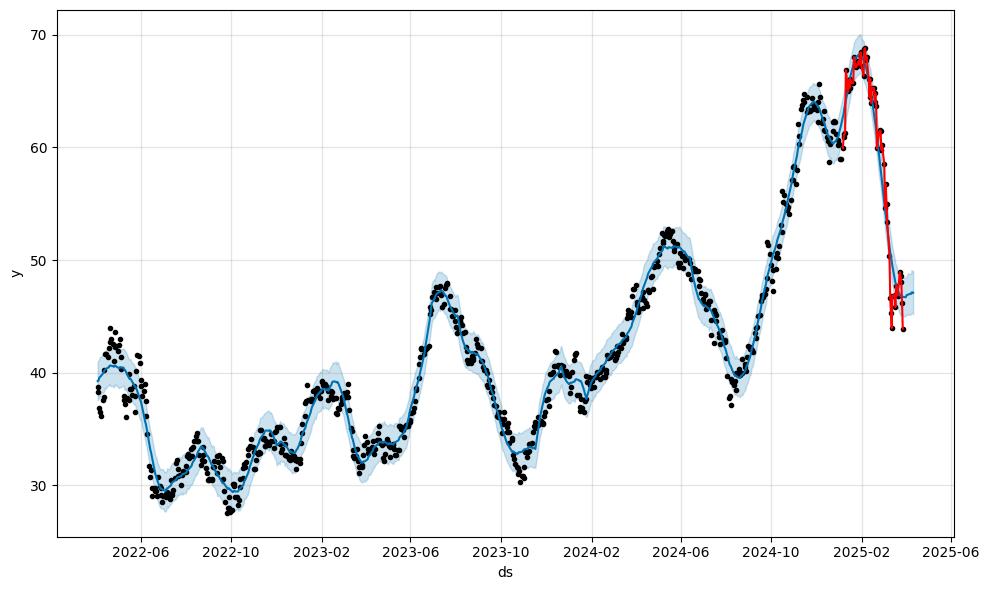

In [528]:
# plot all the predictions

m_best.plot(forecast)
plt.plot(np.exp(test), label='test', color='red');

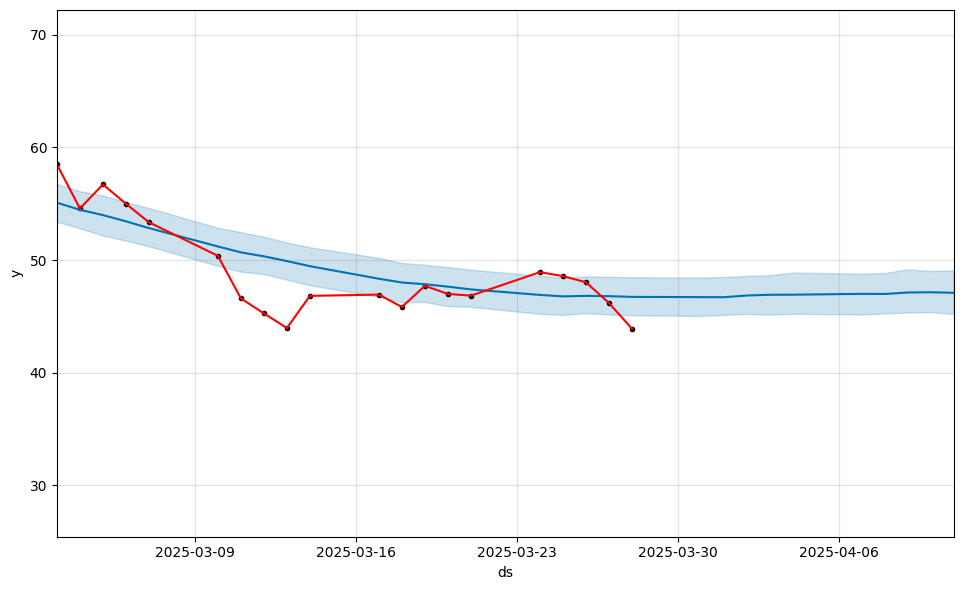

In [529]:
# plot the last 30 predictions, which includes future predictions as well

last_30 = forecast.iloc[-30:]

m_best.plot(forecast)
plt.xlim(last_30['ds'].min(), last_30['ds'].max())
plt.plot(np.exp(test), label='test', color='red');

# Save the predictions to a database

In [530]:
# save the future predictions to a dataframe

prophet_preds = forecast[['ds','yhat']].copy()
prophet_preds_future = prophet_preds[-9:]
prophet_preds_future

,ds,yhat
781,2025-04-01,46.695278
782,2025-04-02,46.848736
783,2025-04-03,46.912184
784,2025-04-04,46.918999
785,2025-04-07,46.994218
786,2025-04-08,46.984384
787,2025-04-09,47.114325
788,2025-04-10,47.136339
789,2025-04-11,47.084669


In [536]:
# convert the dataframe to markdown

print(tabulate(prophet_preds_future, tablefmt="pipe", headers="keys", showindex=False))

| ds                  |    yhat |
|:--------------------|--------:|
| 2025-04-01 00:00:00 | 46.6953 |
| 2025-04-02 00:00:00 | 46.8487 |
| 2025-04-03 00:00:00 | 46.9122 |
| 2025-04-04 00:00:00 | 46.919  |
| 2025-04-07 00:00:00 | 46.9942 |
| 2025-04-08 00:00:00 | 46.9844 |
| 2025-04-09 00:00:00 | 47.1143 |
| 2025-04-10 00:00:00 | 47.1363 |
| 2025-04-11 00:00:00 | 47.0847 |


In [531]:
# save the predictions to csv

prophet_preds_future.to_csv('prophet_predictions.csv', index=True)

In [532]:
# create a new sqlite connection

conn = sqlite3.connect('yfinance.db')

In [533]:
# save the predictions to sql database

prophet_preds_future.to_sql('prophet_predictions', conn, index=True, if_exists='replace')

9

In [534]:
# read from sql table to double check

future_preds_from_sql = pd.read_sql('SELECT * FROM prophet_predictions', conn)
future_preds_from_sql

,index,ds,yhat
0,781,2025-04-01 00:00:00,46.695278
1,782,2025-04-02 00:00:00,46.848736
2,783,2025-04-03 00:00:00,46.912184
3,784,2025-04-04 00:00:00,46.918999
4,785,2025-04-07 00:00:00,46.994218
5,786,2025-04-08 00:00:00,46.984384
6,787,2025-04-09 00:00:00,47.114325
7,788,2025-04-10 00:00:00,47.136339
8,789,2025-04-11 00:00:00,47.084669


In [535]:
# close the sql connection

conn.close()